# Co-registering Images

In this guide, we explore how to combine your MRS data with companion anatomical MR images. We create a voxel mask to identify which voxels of an image fall inside the spectroscopy voxel, and how to visualise the voxel on top of the image, both as a volume and an outline. We also look at resampling the image to better align with the spectroscopy voxel.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import suspect

Here we load the data, in this case a DICOM image set and a GE P-file. For the DICOM volume we pass a single file and the containing folder is processed to collect any other files from the same series, these are then collected into a 3D volume in a `suspect.ImageBase` class, which provides access to a lot of useful functionality around transforms and co-registering. In this case the exam is a single voxel PRESS in the hippocampus, which is convenient as it is a double oblique and very oblong voxel.

In [2]:
image = suspect.image.load_dicom_volume("00004_MPRAGE/i5881167.MRDC.15.img")
data, wref = suspect.io.load_pfile("P75264.e02941.s00007.7")

We start by constructing a voxel mask, passing in the spectroscopy data which defines the excitation region and an image volume which defines the coordinate system for the mask. For display purposes in Matplotlib we then create a "masked" mask using the Numpy MaskedArray class, so that the mask will only be displayed where the mask is true.

In [3]:
voxel_mask = suspect.image.create_mask(data, image)
masked_mask = np.ma.masked_where(voxel_mask == False, voxel_mask)

To draw the voxel outline we must define a set of vertices defining a path which will trace all the edges of the voxel. The list below is the most efficient ordering I can come up with, but feel free to raise an issue on GitHub if you can think of a better one. I am planning to bring this inside Suspect as a property of the MRSBase class so that it is readily available. Note that because this is in the MRS coordinates, the corners of the voxel are universal, irrespective of the size and shape of the voxel.

In [4]:
corner_coords_voxel = [[-0.5, -0.5, -0.5],
                     [0.5, -0.5, -0.5],
                     [0.5, 0.5, -0.5],
                     [-0.5, 0.5, -0.5],
                     [-0.5, -0.5, -0.5],
                     [-0.5, -0.5, 0.5],
                     [0.5, -0.5, 0.5],
                     [0.5, -0.5, -0.5],
                     [0.5, -0.5, 0.5],
                     [0.5, 0.5, 0.5],
                     [0.5, 0.5, -0.5],
                     [0.5, 0.5, 0.5],
                     [-0.5, 0.5, 0.5],
                     [-0.5, 0.5, -0.5],
                     [-0.5, 0.5, 0.5],
                     [-0.5, -0.5, 0.5]]

Here we transform the coordinate system into the coordinates of the image volume. First we use the `to_scanner()` method of the MRS `data` to move the locations of the voxel corners into the scanner space, then use `image.from_scanner()` to bring them into the coordinates of the image volume, which are the voxel indices.

In [5]:
corner_coords = np.array([image.from_scanner(*data.to_scanner(*coord)) for coord in corner_coords_voxel])

The final bit of preparation we are doing here is to calculate where the centre of the MRS voxel is located in the image volume so we know which slice (in each plane) we need to render at the centre of the voxel. Note that coordinates are a bit tricky here - data is organised on the scanner with slices as the outer loop, then columns and then rows, conceptually that means that the z coordinate is the first index into the array, then y and then x. However all manipulation of coordinates in transforms assumes the more conventional ordering of (x, y, z). Thus we find that the centre of the voxel is at slice 58, for example.

In [6]:
voxel_centre_in_image = image.from_scanner(data.position).round().astype(int)
print(voxel_centre_in_image)

[124 132  58]


Now we are ready to actually render the voxels overlaid with the masks and/or voxel outlines. The anatomical scan we started with was a sagittal volume, but of course we can easily extract orthogonal slices either axially or coronally, and in this case the scan is isotropic so we don't even have to worry about rectangular pixels. We do however need to transpose the axial and coronal images to display them in the conventional orientation.

In each case we extract the relevant slice from the image volume, then superimpose the same slice from the masked mask. Finally we plot the line through the corner vertices to show all voxel edges. For the different orientations we need to extract different pairs from the (x,y,z) triples in the `corner_coords` array.

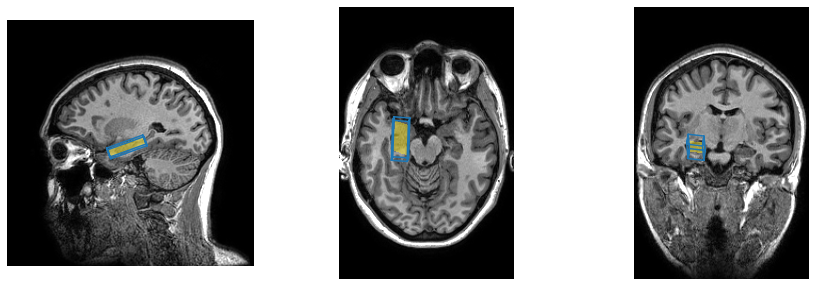

In [7]:
fig, (ax_sag, ax_ax, ax_cor) = plt.subplots(1, 3, figsize=(15, 5))
ax_sag.axis('off')
ax_ax.axis('off')
ax_cor.axis('off')


ax_sag.imshow(image[voxel_centre_in_image[2]], cmap=plt.cm.gray, vmax=1400)
ax_ax.imshow(image[:, voxel_centre_in_image[1]].T, cmap=plt.cm.gray, vmax=1400)
ax_cor.imshow(image[:, :, voxel_centre_in_image[0]].T, cmap=plt.cm.gray, vmax=1400)

ax_sag.imshow(masked_mask[voxel_centre_in_image[2]], cmap=plt.cm.viridis_r, alpha=0.5)
ax_ax.imshow(masked_mask[:, voxel_centre_in_image[1]].T, cmap=plt.cm.viridis_r, alpha=0.5)
ax_cor.imshow(masked_mask[:, :, voxel_centre_in_image[0]].T, cmap=plt.cm.viridis_r, alpha=0.5)

ax_sag.plot(corner_coords[:, 0], corner_coords[:, 1])
ax_ax.plot(corner_coords[:, 2], corner_coords[:, 0])
ax_cor.plot(corner_coords[:, 2], corner_coords[:, 1])

Because the voxel in this case is double oblique it can be difficult to get a good sense of its orientation from either the outline or the mask through a single slice. To help with this problem we can use the `resample()` function to adjust the orientation of the image so that the image direction vectors align with those of the spectroscopy voxel.

Because the image is sagittal and the spectroscopy voxel is axial, it can be complicated to work out which axes to choose. Fortunately, the `MRSData` class provides some helper properties to find the axes which are closest to the axial/sagittal/coronal directions, so we don't need to work out whether we want the slice/column/row directions. The only thing that can trip us up is that the image is acquired with a negative vector in the axial direction, whereas the spectroscopy voxel has a positive one - we solve this by setting a negative voxel size in that direction.

In [8]:
res_image = image.resample(data.coronal_vector,
                           data.axial_vector,
                           image.shape,
                           image.centre,
                           (1, -1, 1),
                           )

We could also resample the mask but that would introduce partial volume effects, so instead we create a new mask from the resampled image. We also get the centre of the voxel in this new, resampled image volume.

In [9]:
mask_res = suspect.image.create_mask(data, res_image)
masked_mask_res = np.ma.masked_where(mask_res == False, mask_res)

voxel_centre_in_res_image = res_image.from_scanner(data.position).round().astype(int)
print(voxel_centre_in_res_image)

[123 133 105]


We now replot the same 3 orthogonal slices as before, but using the resampled image, which puts the spectroscopy voxel perfectly aligned with the image planes.

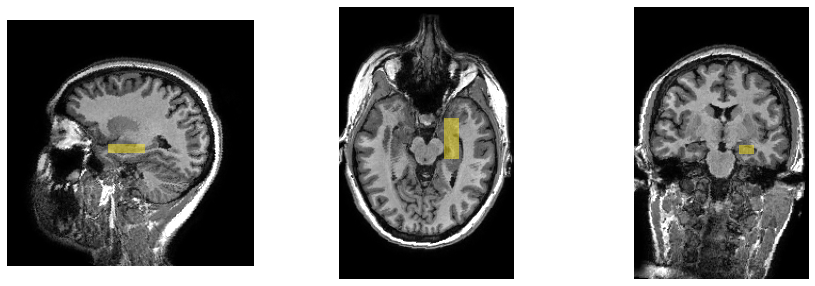

In [10]:
fig, (ax_sag, ax_ax, ax_cor) = plt.subplots(1, 3, figsize=(15, 5))
ax_sag.axis('off')
ax_ax.axis('off')
ax_cor.axis('off')

ax_sag.imshow(res_image[voxel_centre_in_res_image[2]], cmap=plt.cm.gray, vmax=1400)
ax_ax.imshow(res_image[:, voxel_centre_in_res_image[1]].T, cmap=plt.cm.gray, vmax=1400)
ax_cor.imshow(res_image[:, :, voxel_centre_in_res_image[0]].T, cmap=plt.cm.gray, vmax=1400)

ax_sag.imshow(masked_mask_res[voxel_centre_in_res_image[2]], cmap=plt.cm.viridis_r, alpha=0.5)
ax_ax.imshow(masked_mask_res[:, voxel_centre_in_res_image[1]].T, cmap=plt.cm.viridis_r, alpha=0.5)
ax_cor.imshow(masked_mask_res[:, :, voxel_centre_in_res_image[0]].T, cmap=plt.cm.viridis_r, alpha=0.5)

We hope you have found this brief exploration of how to combine MRS and MRI data together. If you have questions, or suggestions on how to improve this guide, please raise an issue on the [Suspect GitHub page](https://github.com/openmrslab/suspect/), or post something in the [MRSHub forum](https://forum.mrshub.org).